In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cybersecurity-suspicious-web-threat-interactions:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4890148%2F8243215%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240517%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240517T162458Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D8b7c40360b5a2d5d7468a347b59de9e347eac9daa3057c73058f6f634792b7fdf389f16e39497634aa24a0488e0a787e6402daa50d2cf8b9b403b638163644177c7abd2dd4814fd6cfb2112d6113a286d0ad752c6d1ae89e52d3b116ded92c5bea9563016e364d660a92c86b644892914cbb708992efea45fe5df588474652e5adb9b8237940fe9879ff76fc3faa5171350b00eed357fb8adde6a58d828ff0444a0551e1ac4d12b81b7d1aef37202d296fd29c8b24475627e6fd6b71c1017da7b51b506622299e6e74c5f1fdecfae2fc13fb854f6d458e20bd6a2bfdef86277f5b6fd5b4a1b6fc0571ae1960961a19d9d2202434916b19647d59a0d864ccb2af'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 4466 bytes downloaded
Downloaded and uncompressed: cybersecurity-suspicious-web-threat-interactions
Data source import complete.


Each entry in the dataset represents a stream of traffic that is deemed suspicious based on a set of criteria. The dataset contains information on records of web traffic. To provide a brief summary of the columns and the meanings associated with them:

-  bytes_in : Bytes received by the server.
-  bytes_out : Bytes sent from the server.
-  creation_time : Timestamp of when the record was created.
-  end_time : Timestamp of when the connection ended.
-  src_ip : Source IP address.
-  src_ip_country_code : Country code of the source IP.
-  protocol : Protocol used in the connection.
-  response.code : HTTP response code.
-  dst_port : Destination port on the server.
-  dst_ip : Destination IP address.
-  rule_names : Name of the rule that identified the traffic as suspicious.
-  observation_name : Observations associated with the traffic.
-  source.meta : Metadata related to the source.
-  source.name : Name of the traffic source.
-  time : Timestamp of the detected event.
-  detection_types : Type of detection applied.

# Module Importing

In [2]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load the data into a DataFrame
data = pd.read_csv("/kaggle/input/cybersecurity-suspicious-web-threat-interactions/CloudWatch_Traffic_Web_Attack.csv")
# Display the first few rows of the DataFrame to understand its structure
data.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


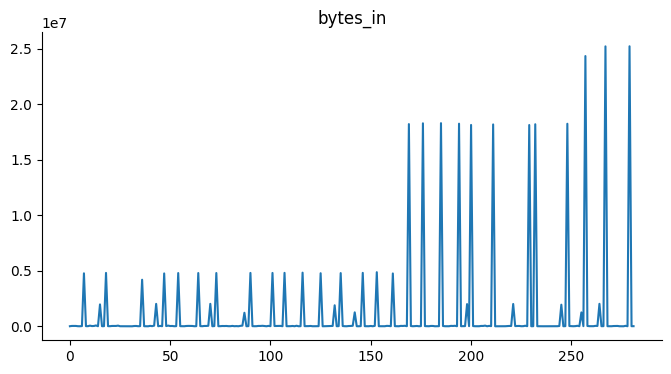

In [5]:
# @title bytes_in

from matplotlib import pyplot as plt
data['bytes_in'].plot(kind='line', figsize=(8, 4), title='bytes_in')
plt.gca().spines[['top', 'right']].set_visible(False)

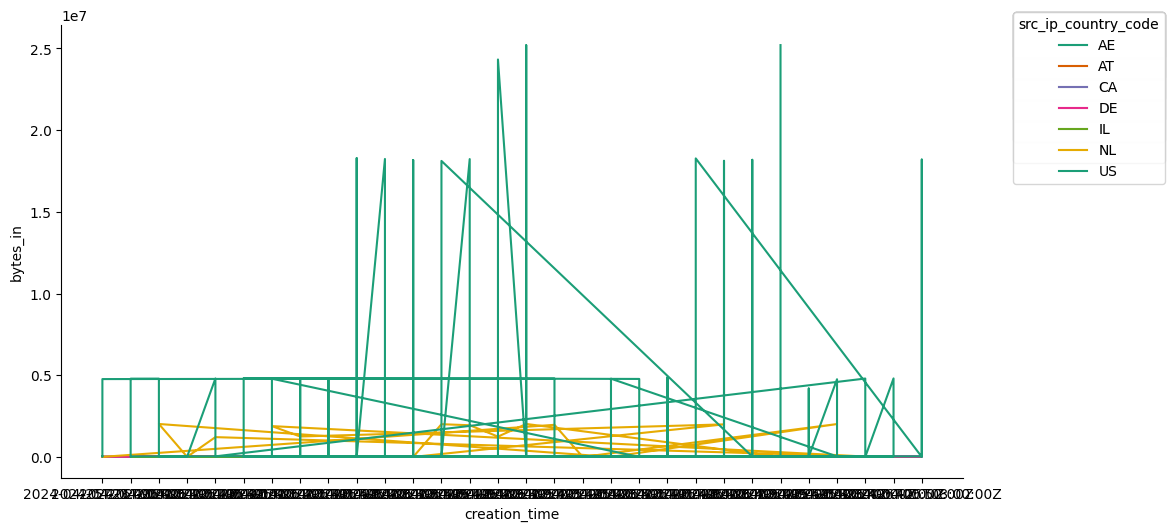

In [4]:
# @title creation_time vs bytes_in

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['creation_time']
  ys = series['bytes_in']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('creation_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('src_ip_country_code')):
  _plot_series(series, series_name, i)
  fig.legend(title='src_ip_country_code', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('creation_time')
_ = plt.ylabel('bytes_in')

# Data Preparation

## Handling Missing Data

In [6]:
# Remove duplicate rows
df_unique = data.drop_duplicates()
# Convert time-related columns to datetime format
df_unique['creation_time'] = pd.to_datetime(df_unique['creation_time'])
df_unique['end_time'] = pd.to_datetime(df_unique['end_time'])
df_unique['time'] = pd.to_datetime(df_unique['time'])
# Standardize text data (example: convert to lower case)
df_unique['src_ip_country_code'] = df_unique['src_ip_country_code'].str.upper()  # Ensuring country codes are all upper case
# Display changes and current state of the DataFrame
print("Unique Datasets Information:")
df_unique.info()

Unique Datasets Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   bytes_in             282 non-null    int64              
 1   bytes_out            282 non-null    int64              
 2   creation_time        282 non-null    datetime64[ns, UTC]
 3   end_time             282 non-null    datetime64[ns, UTC]
 4   src_ip               282 non-null    object             
 5   src_ip_country_code  282 non-null    object             
 6   protocol             282 non-null    object             
 7   response.code        282 non-null    int64              
 8   dst_port             282 non-null    int64              
 9   dst_ip               282 non-null    object             
 10  rule_names           282 non-null    object             
 11  observation_name     282 non-null    object            

In [7]:
print("Top 5 Unique Datasets Information:")
df_unique.head()

Top 5 Unique Datasets Information:


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25 23:00:00+00:00,waf_rule


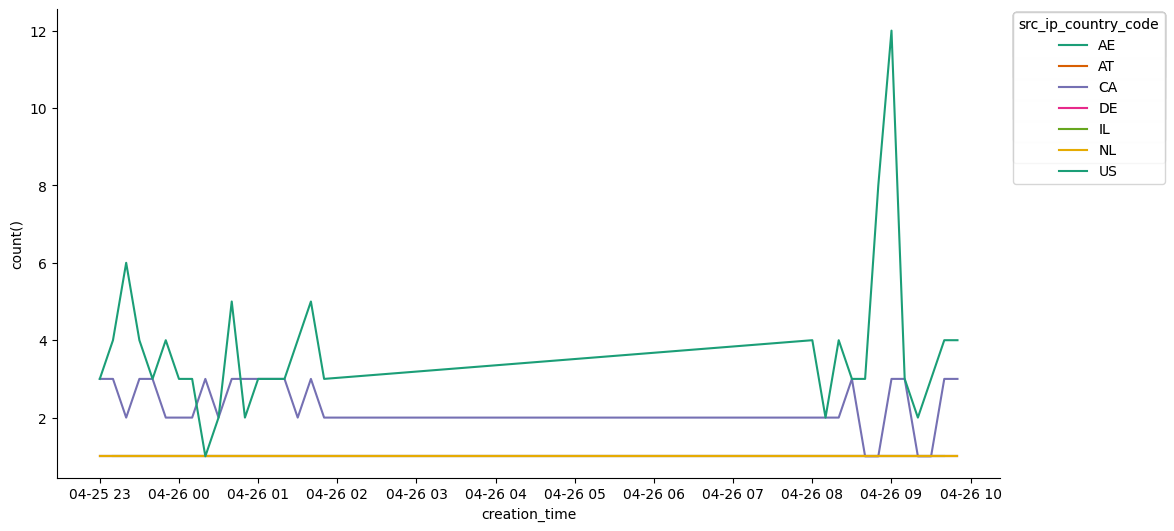

In [9]:
# @title creation_time vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['creation_time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'creation_time'}, axis=1)
              .sort_values('creation_time', ascending=True))
  xs = counted['creation_time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_unique.sort_values('creation_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('src_ip_country_code')):
  _plot_series(series, series_name, i)
  fig.legend(title='src_ip_country_code', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('creation_time')
_ = plt.ylabel('count()')

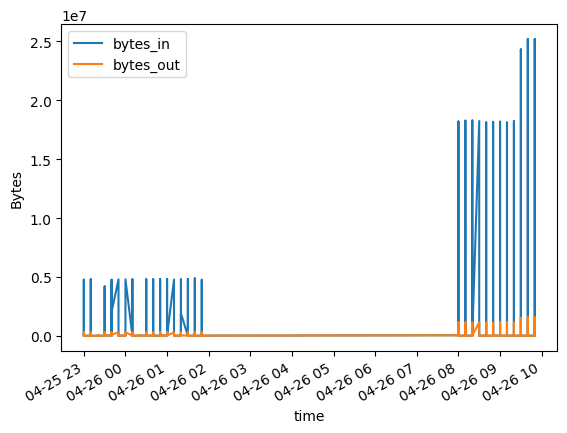

In [8]:
# @title Bytes In vs Bytes Out over time

import matplotlib.pyplot as plt
df_unique.plot.line(x='time', y=['bytes_in', 'bytes_out'])
_ = plt.ylabel('Bytes')

# Data Transformation

When it comes to preparing our dataset for machine learning models, one of the most important steps is data transformation. This phase helps to standardize or normalize the data, which in turn makes it simpler for the models to learn and generate correct predictions. Listed below are some of the more typical methods of data transformation that you could use:


### 1.  Normalization and Scaling
Normalization or scaling ensures that numeric features contribute equally to model training. Common methods include:

-  Min-Max Scaling : Transforms features to a fixed range, usually 0 to 1.
-  Standardization (Z-score Scaling) : Centers the data by removing the mean and scales it by the standard deviation to achieve a variance of 1 and mean of 0.

### 2.  Encoding Categorical Data
Machine learning models generally require all input and output variables to be numeric. This means that categorical data must be converted into a numerical format.

-  One-Hot Encoding : Creates a binary column for each category and returns a matrix with 1s and 0s.
-  Label Encoding : Converts each value in a column to a number.

### 3.  Feature Engineering
Feature engineering is the process of using domain knowledge to select, modify, or create new features that increase the predictive power of the learning algorithm.

-  Polynomial Features : Derive new feature interactions.
-  Binning : Convert numerical values into categorical bins.

### Applying These Transformations
Now will try to apply some of these transformations to our dataset:

1.  Scale the `bytes_in` and `bytes_out` columns  using Standardization.
2.  One-hot encode the `src_ip_country_code` column  since it is a categorical feature.
3.  Feature engineering example : Create a new feature that measures the duration of the connection based on `creation_time` and `end_time`.

Now we will start with these transformations.

1.  Scaling : The `bytes_in`, `bytes_out`, and the newly created `duration_seconds` (which captures the duration of the connection) columns have been standardized using z-score scaling. This means their mean is now 0 and standard deviation is 1, which helps in normalizing the data for better performance of many machine learning algorithms.

2.  One-Hot Encoding : The `src_ip_country_code` column has been one-hot encoded. This has transformed each country code into its own feature, allowing categorical data to be used effectively in machine learning models.

3.  Feature Engineering : A new feature `duration_seconds` was added to measure the duration of each web session.


In [10]:
# Feature engineering: Calculate duration of connection
df_unique['duration_seconds'] = (df_unique['end_time'] - df_unique['creation_time']).dt.total_seconds()

# Preparing column transformations
# StandardScaler for numerical features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_unique[['bytes_in', 'bytes_out', 'duration_seconds']])

In [11]:
# OneHotEncoder for categorical features
encoder = OneHotEncoder(sparse=False)
encoded_features = encoder.fit_transform(df_unique[['src_ip_country_code']])

# Combining transformed features back into the DataFrame
scaled_columns = ['scaled_bytes_in', 'scaled_bytes_out', 'scaled_duration_seconds']
encoded_columns = encoder.get_feature_names_out(['src_ip_country_code'])

In [12]:
# Convert numpy arrays back to DataFrame
scaled_df = pd.DataFrame(scaled_features, columns=scaled_columns, index=df_unique.index)
encoded_df = pd.DataFrame(encoded_features, columns=encoded_columns, index=df_unique.index)

# Concatenate all the data back together
transformed_df = pd.concat([df_unique, scaled_df, encoded_df], axis=1)
# Displaying the transformed data
transformed_df.head()

,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,...,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
0,5602,12990,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,...,-0.288219,-0.281223,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,30912,18186,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.33.6,US,HTTPS,200,443,10.138.69.97,...,-0.282108,-0.260804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,28506,13468,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,...,-0.282689,-0.279344,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,30546,14278,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,136.226.64.114,US,HTTPS,200,443,10.138.69.97,...,-0.282197,-0.276161,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,6526,13892,2024-04-25 23:00:00+00:00,2024-04-25 23:10:00+00:00,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,...,-0.287996,-0.277678,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


from matplotlib import pyplot as plt
_df_0['bytes_in'].plot(kind='hist', bins=20, title='bytes_in')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['bytes_out'].plot(kind='hist', bins=20, title='bytes_out')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['scaled_bytes_in'].plot(kind='hist', bins=20, title='scaled_bytes_in')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['scaled_bytes_out'].plot(kind='hist', bins=20, title='scaled_bytes_out')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('src_ip').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_5.groupby('src_ip_country_code').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='bytes_in', y='bytes_out', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='bytes_out', y='scaled_bytes_in', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='scaled_bytes_in', y='scaled_bytes_out', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='scaled_bytes_out', y='src_ip_country_code_AE', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['creation_time']
  ys = series['bytes_in']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('creation_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('src_ip')):
  _plot_series(series, series_name, i)
  fig.legend(title='src_ip', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('creation_time')
_ = plt.ylabel('bytes_in')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['creation_time']
  ys = series['bytes_in']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('creation_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('src_ip_country_code')):
  _plot_series(series, series_name, i)
  fig.legend(title='src_ip_country_code', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('creation_time')
_ = plt.ylabel('bytes_in')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['creation_time']
  ys = series['bytes_out']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('creation_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('src_ip')):
  _plot_series(series, series_name, i)
  fig.legend(title='src_ip', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('creation_time')
_ = plt.ylabel('bytes_out')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['creation_time']
  ys = series['bytes_out']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('creation_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('src_ip_country_code')):
  _plot_series(series, series_name, i)
  fig.legend(title='src_ip_country_code', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('creation_time')
_ = plt.ylabel('bytes_out')

from matplotlib import pyplot as plt
_df_14['bytes_in'].plot(kind='line', figsize=(8, 4), title='bytes_in')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['bytes_out'].plot(kind='line', figsize=(8, 4), title='bytes_out')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['scaled_bytes_in'].plot(kind='line', figsize=(8, 4), title='scaled_bytes_in')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['scaled_bytes_out'].plot(kind='line', figsize=(8, 4), title='scaled_bytes_out')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['src_ip_country_code'].value_counts()
    for x_label, grp in _df_18.groupby('src_ip')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('src_ip')
_ = plt.ylabel('src_ip_country_code')

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['src_ip'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='bytes_in', y='src_ip', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['src_ip_country_code'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='bytes_in', y='src_ip_country_code', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_21['src_ip'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_21, x='bytes_out', y='src_ip', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['src_ip_country_code'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='bytes_out', y='src_ip_country_code', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

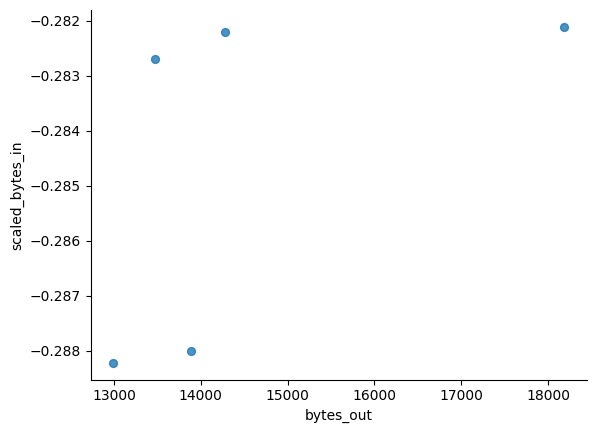

In [13]:
from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='bytes_out', y='scaled_bytes_in', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

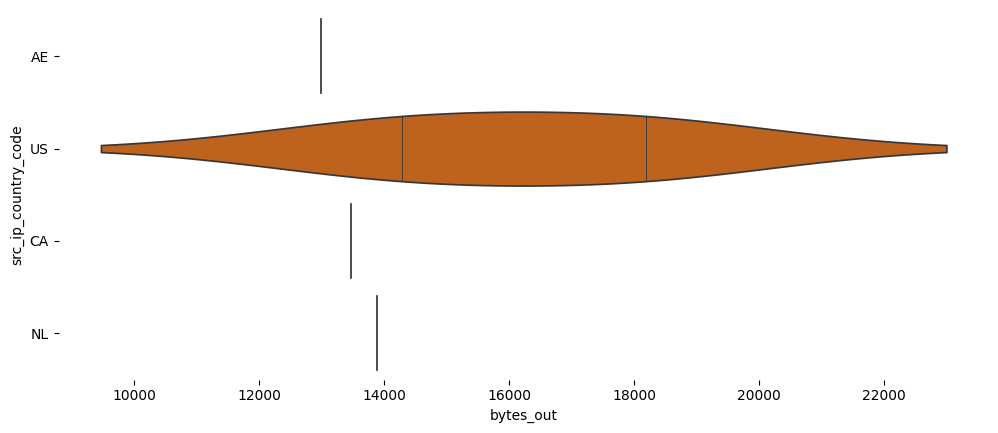

In [14]:
from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_22['src_ip_country_code'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_22, x='bytes_out', y='src_ip_country_code', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

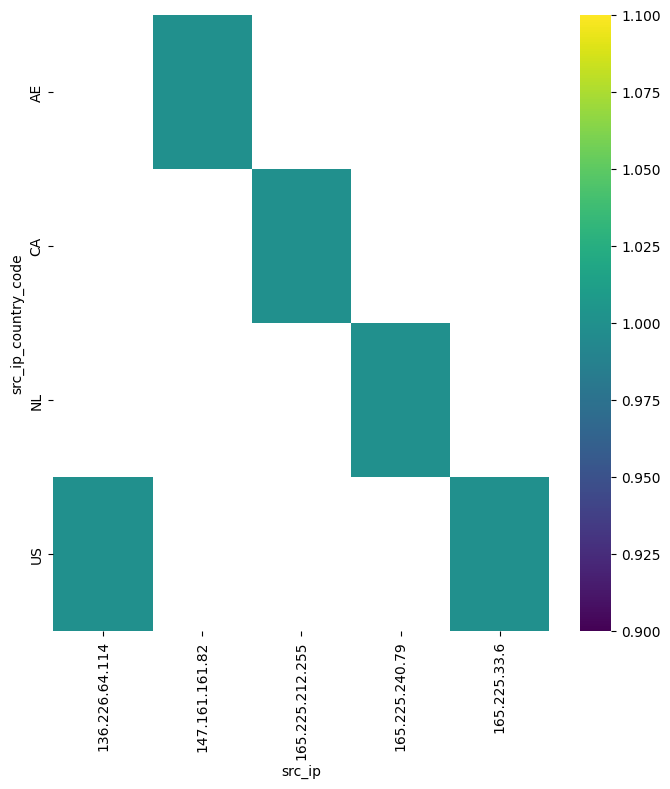

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['src_ip_country_code'].value_counts()
    for x_label, grp in _df_18.groupby('src_ip')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('src_ip')
_ = plt.ylabel('src_ip_country_code')

# Exploratory Data Analysis (EDA)

A significant stage in the process of summarizing, describing, and comprehending the underlying patterns in the data is the performing of statistical analysis. Examining several aspects such as distributions, central trends, variability, and correlations between characteristics is included in this. On your converted dataset, let's carry out a number of statistical analysis, including the following:


1. <span style="color: blue; font-weight: bold;"> Descriptive Statistics :</span> This includes mean, median, mode, min, max, range, quartiles, and standard deviations.
2. <span style="color: blue; font-weight: bold;"> Correlation Analysis :</span> To investigate the relationships between numerical features and how they relate to each other.
3. <span style="color: blue; font-weight: bold;"> Distribution Analysis :</span> Examine the distribution of key features using histograms and box plots to identify the spread and presence of outliers.


### <span style="color: red; font-weight: bold;"> Descriptive Statistics </span>

The descriptive statistics provide a summary of the key statistical characteristics of the numerical features:

-  `bytes_in` and `bytes_out` : These columns have a high standard deviation relative to their mean, indicating significant variability. This could be reflective of different types of web sessions or activities.
-  `response.code` and `dst_port` : These fields are constants in the dataset (200 and 443, respectively), indicating all records are using HTTPS protocol on standard port 443 and receiving a standard HTTP 200 OK response.
-  `duration_seconds` : It's also constant (600 seconds), which suggests that each session or observation is recorded over a fixed interval.
-  Scaled Features : The scaled versions of `bytes_in`, `bytes_out`, and `duration_seconds` have a mean of approximately 0 and a standard deviation of 1, as expected after standardization.

In [16]:
# Compute correlation matrix for numeric columns only
numeric_df = transformed_df.select_dtypes(include=['float64', 'int64'])
correlation_matrix_numeric = numeric_df.corr()
# Display the correlation matrix
correlation_matrix_numeric

,bytes_in,bytes_out,response.code,dst_port,duration_seconds,scaled_bytes_in,scaled_bytes_out,scaled_duration_seconds,src_ip_country_code_AE,src_ip_country_code_AT,src_ip_country_code_CA,src_ip_country_code_DE,src_ip_country_code_IL,src_ip_country_code_NL,src_ip_country_code_US
bytes_in,1.000000,0.997705,NaN,NaN,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
response.code,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dst_port,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
scaled_bytes_in,1.000000,0.997705,NaN,NaN,NaN,1.000000,0.997705,NaN,-0.070559,-0.081670,-0.166488,-0.095333,-0.065939,-0.006827,0.316015
scaled_bytes_out,0.997705,1.000000,NaN,NaN,NaN,0.997705,1.000000,NaN,-0.072452,-0.081777,-0.159587,-0.090001,-0.067630,-0.045641,0.327683
scaled_duration_seconds,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
src_ip_country_code_AE,-0.070559,-0.072452,NaN,NaN,NaN,-0.070559,-0.072452,NaN,1.000000,-0.069568,-0.143607,-0.081429,-0.056055,-0.064040,-0.200546
src_ip_country_code_AT,-0.081670,-0.081777,NaN,NaN,NaN,-0.081670,-0.081777,NaN,-0.069568,1.000000,-0.166091,-0.094178,-0.064831,-0.074067,-0.231945


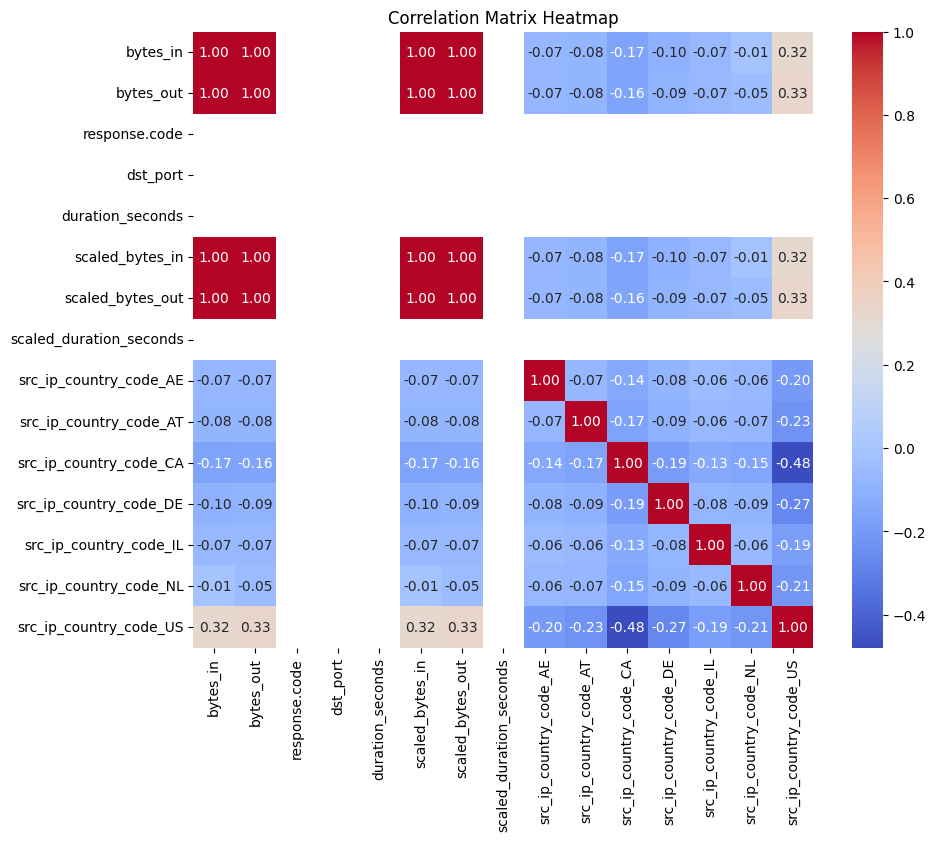

In [17]:
# Heatmap for the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_numeric, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix Heatmap')
plt.show()

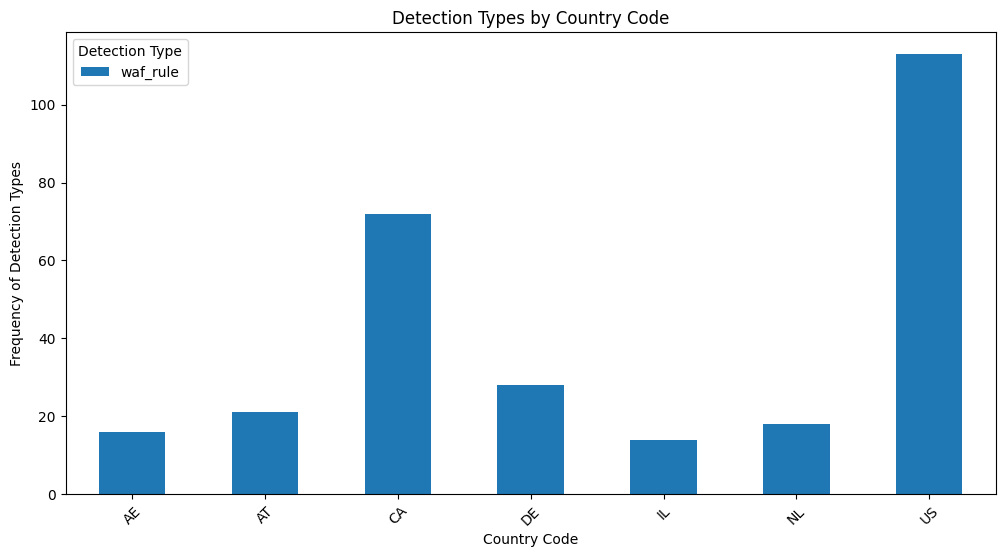

In [18]:
# Stacked Bar Chart for Detection Types by Country
# Preparing data for stacked bar chart
detection_types_by_country = pd.crosstab(transformed_df['src_ip_country_code'], transformed_df['detection_types'])
detection_types_by_country.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Detection Types by Country Code')
plt.xlabel('Country Code')
plt.ylabel('Frequency of Detection Types')
plt.xticks(rotation=45)
plt.legend(title='Detection Type')
plt.show()


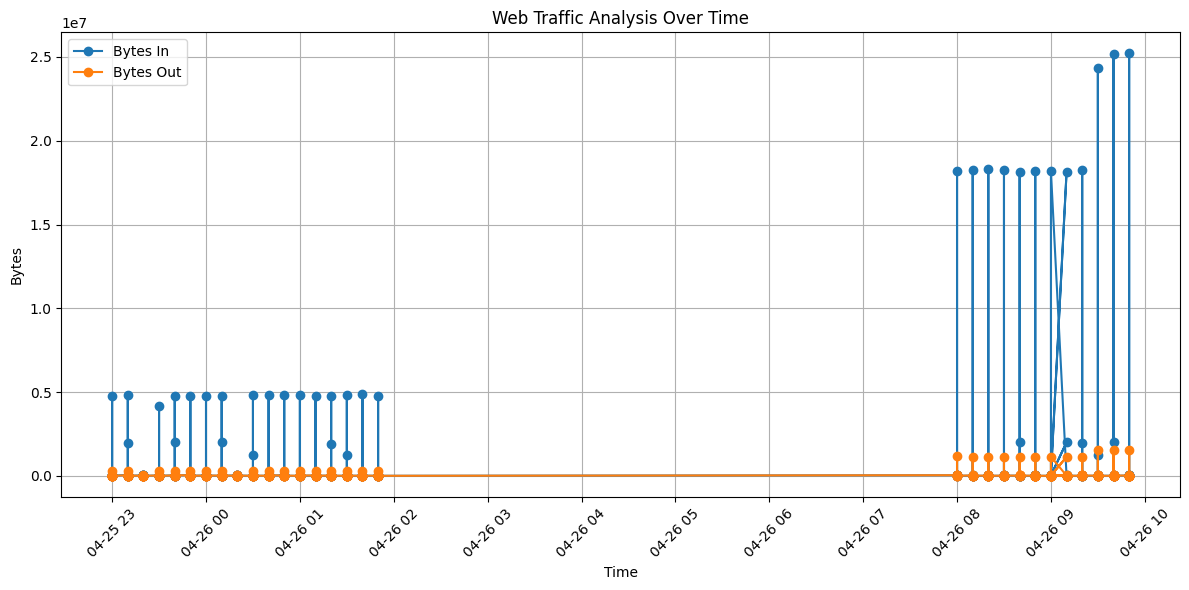

In [19]:
# Convert 'creation_time' to datetime format
data['creation_time'] = pd.to_datetime(data['creation_time'])

# Set 'creation_time' as the index
data.set_index('creation_time', inplace=True)

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['bytes_in'], label='Bytes In', marker='o')
plt.plot(data.index, data['bytes_out'], label='Bytes Out', marker='o')
plt.title('Web Traffic Analysis Over Time')
plt.xlabel('Time')
plt.ylabel('Bytes')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


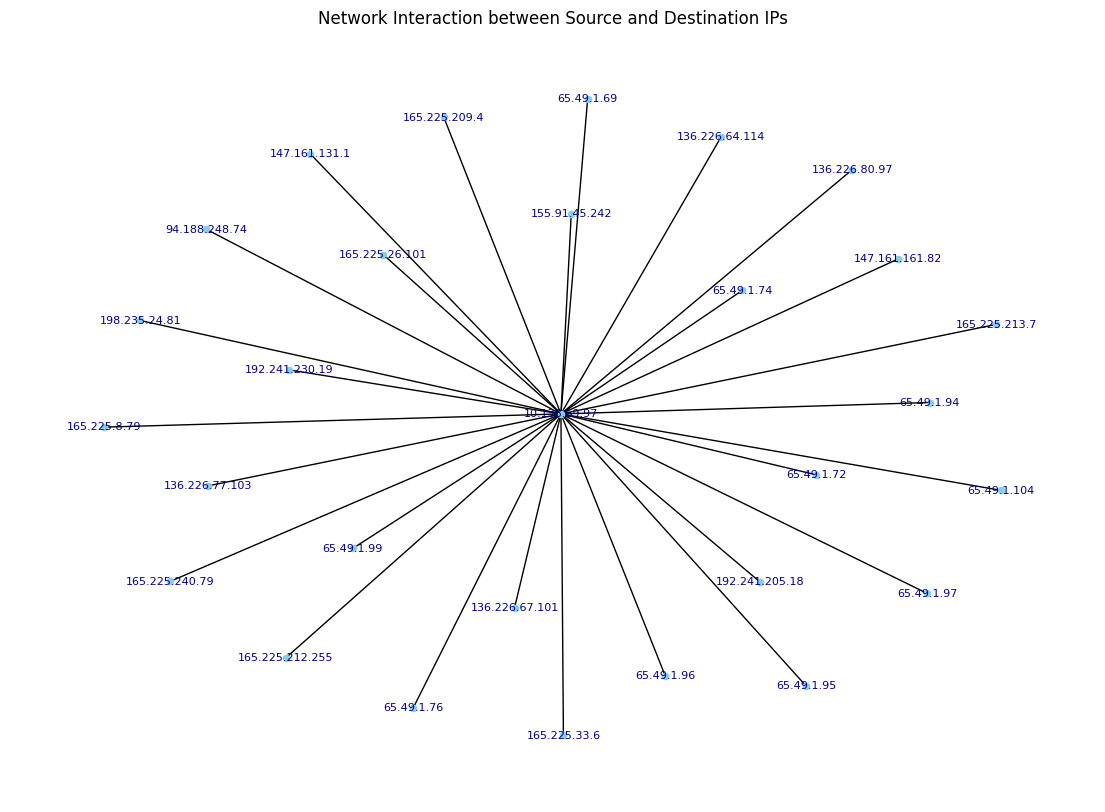

In [20]:
# Create a graph
G = nx.Graph()

# Add edges from source IP to destination IP
for idx, row in data.iterrows():
    G.add_edge(row['src_ip'], row['dst_ip'])

# Draw the network graph
plt.figure(figsize=(14, 10))
nx.draw_networkx(G, with_labels=True, node_size=20, font_size=8, node_color='skyblue', font_color='darkblue')
plt.title('Network Interaction between Source and Destination IPs')
plt.axis('off')  # Turn off the axis

# Show the plot
plt.show()


# RandomForestClassifier

In [21]:
# First, encode this column into binary labels
transformed_df['is_suspicious'] = (transformed_df['detection_types'] == 'waf_rule').astype(int)

# Features and Labels
X = transformed_df[['bytes_in', 'bytes_out', 'scaled_duration_seconds']]  # Numeric features
y = transformed_df['is_suspicious']  # Binary labels

In [22]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

In [24]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification = classification_report(y_test, y_pred)

In [25]:
print("Model Accuracy: ",accuracy)

Model Accuracy:  1.0


In [26]:
print("Classification Report: ",classification)

Classification Report:                precision    recall  f1-score   support

           1       1.00      1.00      1.00        85

    accuracy                           1.00        85
   macro avg       1.00      1.00      1.00        85
weighted avg       1.00      1.00      1.00        85



# Neural Network

In [28]:
data['is_suspicious'] = (data['detection_types'] == 'waf_rule').astype(int)

# Features and labels
X = data[['bytes_in', 'bytes_out']].values  # Using only numeric features
y = data['is_suspicious'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Neural network model
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history  = model.fit(X_train_scaled, y_train, epochs=10, batch_size=8, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

Epoch 1/10
25/25 [==============================] - 2s 2ms/step - loss: 0.6493 - accuracy: 0.9594
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 0.5682 - accuracy: 1.0000
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 0.4704 - accuracy: 1.0000
Epoch 4/10
25/25 [==============================] - 0s 3ms/step - loss: 0.3605 - accuracy: 1.0000
Epoch 5/10
25/25 [==============================] - 0s 2ms/step - loss: 0.2560 - accuracy: 1.0000
Epoch 6/10
25/25 [==============================] - 0s 2ms/step - loss: 0.1660 - accuracy: 1.0000
Epoch 7/10
25/25 [==============================] - 0s 2ms/step - loss: 0.1044 - accuracy: 1.0000
Epoch 8/10
25/25 [==============================] - 0s 3ms/step - loss: 0.0668 - accuracy: 1.0000
Epoch 9/10
25/25 [==============================] - 0s 2ms/step - loss: 0.0434 - accuracy: 1.0000
Epoch 10/10
3/3 [==============================] - 0s 5ms/step - loss: 0.0260 - accuracy: 1.0000
Test Accuracy: 100.00

Epoch 1/10
5/5 [==============================] - 1s 50ms/step - loss: 0.6657 - accuracy: 0.8662 - val_loss: 0.5704 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 0s 10ms/step - loss: 0.5692 - accuracy: 0.9936 - val_loss: 0.4818 - val_accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 0s 15ms/step - loss: 0.4899 - accuracy: 1.0000 - val_loss: 0.3987 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 0s 12ms/step - loss: 0.3993 - accuracy: 1.0000 - val_loss: 0.3174 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 0s 11ms/step - loss: 0.3129 - accuracy: 1.0000 - val_loss: 0.2388 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 0s 15ms/step - loss: 0.2397 - accuracy: 1.0000 - val_loss: 0.1684 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 0s 15ms/step - loss: 0.1668 - accuracy: 1.0000 - val_loss: 0.1119 - val_accuracy: 1.0000
Epoch 8/10
5/5 [===========

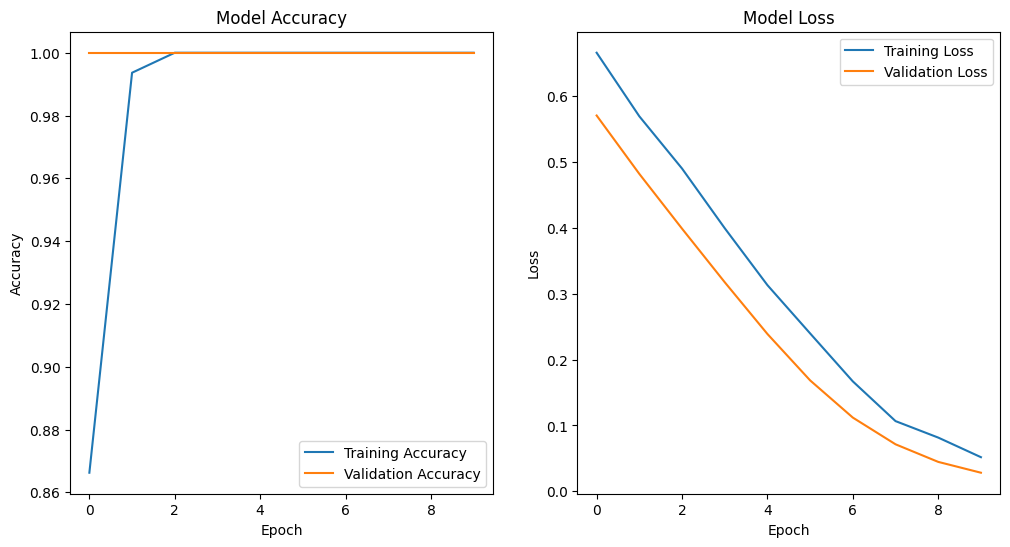

In [29]:
# Neural network model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plotting the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Epoch 1/10
5/5 [==============================] - 2s 117ms/step - loss: 0.7084 - accuracy: 0.4650 - val_loss: 0.6595 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 0s 23ms/step - loss: 0.6460 - accuracy: 0.9363 - val_loss: 0.6018 - val_accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 0s 20ms/step - loss: 0.6163 - accuracy: 0.9873 - val_loss: 0.5613 - val_accuracy: 1.0000
Epoch 4/10
5/5 [==============================] - 0s 20ms/step - loss: 0.5728 - accuracy: 1.0000 - val_loss: 0.5282 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 0s 48ms/step - loss: 0.5490 - accuracy: 1.0000 - val_loss: 0.4951 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 0s 64ms/step - loss: 0.5180 - accuracy: 1.0000 - val_loss: 0.4599 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 0s 36ms/step - loss: 0.4840 - accuracy: 1.0000 - val_loss: 0.4223 - val_accuracy: 1.0000
Epoch 8/10
5/5 [==========

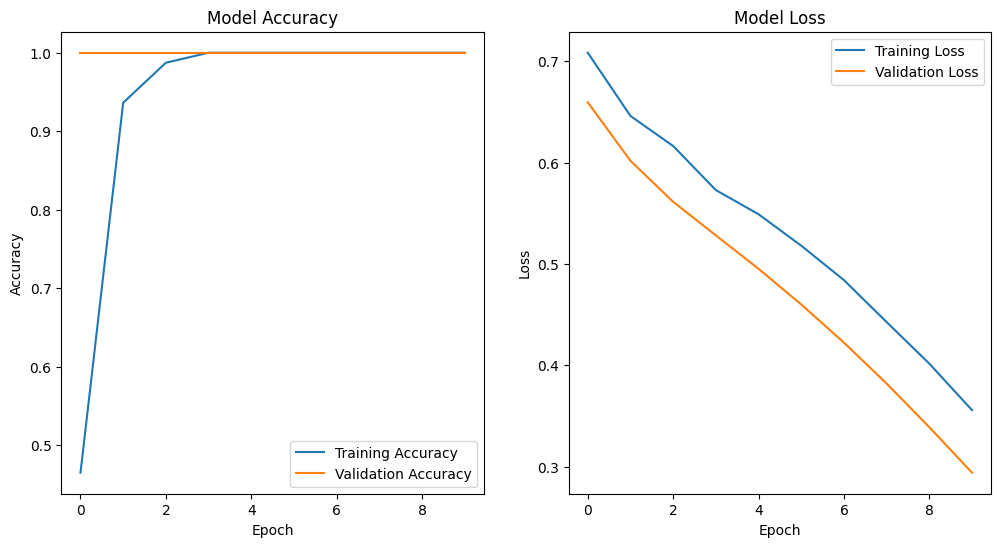

In [30]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Adjusting the network to accommodate the input size
model = Sequential([
    Conv1D(32, kernel_size=1, activation='relu', input_shape=(X_train_scaled.shape[1], 1)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=1, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# Plotting the training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()